# Kapitel 4

### Perceptron-Lernalgorithmus

Gewichtsvektor am Ende des Trainings:
[-1.  1.  1.]
Auswertung am Ende des Trainings:
[1 0 0]: 0 -> 0
[1 0 1]: 1 -> 1
[1 1 0]: 1 -> 1
[1 1 1]: 1 -> 1


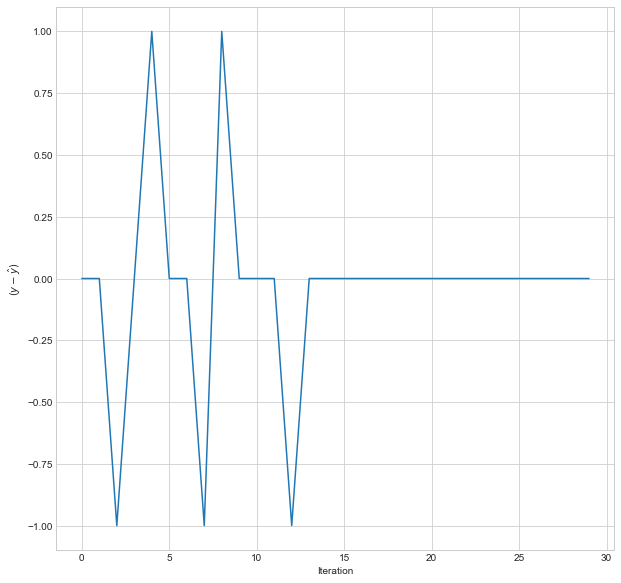

In [71]:
import matplotlib.pyplot as plt
from random import choice
from numpy import array, dot, zeros, random
%matplotlib inline

heaviside = lambda x: 0 if x < 0 else 1

# Training
def fit(iterations, training_data_set, w):
  """ Lernen im Perceptron
  
  iterations: Ein Vorwärts- und Rückwärtslauf aller Trainingsbeispiele
  trainings_data_set: Die Trainingsbeispiele
  w: Die Gewichte zum Starten
  """
  errors = []
  weights = []

  for i in range(iterations):
    # Zufällige Auswahl eines Trainingsbeispiels
    training_data = choice(training_data_set)
    x = training_data[0]
    y = training_data[1]
    # Den errechneten Output ermitteln: Gewichtete Summe mit
    # nachgelagerter Stufenfunktion
    y_hat = heaviside(dot(w, x))
    # Fehler berechnen als Differenz zwischen gewünschtem und
    # tatsächlichem Output
    error = y - y_hat
    # Fehler sammeln für die Ausgabe
    errors.append(error)
    #Gewichte sammeln für spätere Ausgabe
    weights.append(w)
    # Gewichtsanpassung = Das Lernen
    # x_i ist entweder 0 oder 1
    w += error * x
  
  return errors, weights


def main():
  """ Hauptprogram
  Hier werden die einzelnen Bausteine zusammengesetzt
  """
  # Trainingsdaten
  # Pro Zeile: die binären Inputdaten und die gewünschte binäre Ausgabe
  # in einer Liste von Tupeln
  # An der Indexposition 0 des Inputvektors ist das Bias-Neuron
  training_data_set = [
    (array([1, 0, 0]), 0),
    (array([1, 0, 1]), 1),
    (array([1, 1, 0]), 1),
    (array([1, 1, 1]), 1),
  ]

  # Anfangsinitialisierung des Zufallsgenerators wegen
  # Reproduzierbarkeit der Ergebnisse
  random.seed(12)
  # Array von Länge 3 mit 0 initialisieren
  w = zeros(3)
  # Die Anzahl der Durchläufe. Erfahrungswert durch probieren
  iterations = 30

  # Trainieren mit fit()
  # Wir sammeln die Fehler/Gewichte in jedem Schritt für die grafische Ausgabe
  errors, weights = fit(iterations, training_data_set, w)
  # Den letzten Gewichtsvektor ausgeben
  w = weights[iterations - 1]
  print("Gewichtsvektor am Ende des Trainings:")
  print(w)

  # Auswertung nach dem Trainieren
  print("Auswertung am Ende des Trainings:")
  for x, y in training_data_set:
    y_hat = heaviside(dot(w, x))
    print("{}: {} -> {}".format(x, y, y_hat))

  # Grafik für Fehler pro Lernbeispiel
  fignr = 1
  # Druckgröße in inch
  plt.figure(fignr, figsize=(10, 10))
  # Ausgabe der Fehler als Plot
  plt.plot(errors)
  # Plot konfigurieren
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Iteration')
  plt.ylabel(r"$(y - \hat y)$")
  # Anzeigen
  plt.show()


main()

### scikit-learn-kompatibler Estimator

[1 0 0]: 0 -> 0
[1 0 1]: 1 -> 1
[1 1 0]: 1 -> 1
[1 1 1]: 1 -> 1


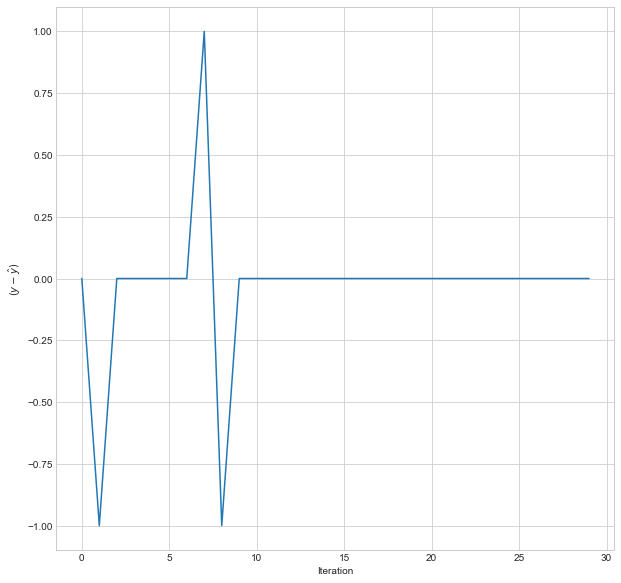

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

class PerceptronEstimator(BaseEstimator, ClassifierMixin):
  def __init__(self, n_iterations=20, random_state=None):
    """ Initialisierung der Objekte
    n_iterations: Anzahl der Iterationen für das Lernen
    random_state: Um Wiederholbarkeit zu garantieren, sollte ein
      numpy.random.RandomState-Objekt konstruiert werden, das mit
      random_state-Seed initialisiert wurde
    """
    self.n_iterations = n_iterations
    self.random_state = random_state
    # Die Fehler im Lernprozess für den Plot gepuffert
    self.errors = []

  def heaviside(self, x):
    """ Die Stufenfunktion
    x: Der Wert, der für die Stufenfunktion ausgewertet wird
    """
    if x < 0:
      result = 0
    else:
      result = 1
    return result

  def fit(self, X=None, y=None):
    """ Trainieren
    X: Array-ähnliche Struktur mit [N, D], wobei
      N = Zeilen = Anzahl der Lernbeispiele und
      D = Spalten = Anzahl der Features
    y: Array mit [N], mit N so wie oben
    """
    # Erzeugung des Zufallsgenerators (RNG)
    random_state = check_random_state(self.random_state)
    # Gewichtsinitialisierung
    # np.size(.,1) = Anzahl der Spalten
    self.w = random_state.random_sample(np.size(X, 1))
    # Prüfe, ob X und y die korrekte Shape haben
    X, y = check_X_y(X, y)
    # Die eindeutigen Zielwerte speichern
    self.classes_ = unique_labels(y)
    # Lerndaten für spätere Prüfung in Methode predict speichern
    self.X_ = X
    self.y_ = y

    # Lernen
    for i in range(self.n_iterations):
      # zufälliges Durchwürfeln für Batch-Size = 1
      # np.size(.,0) = Anzahl der Zeilen
      rand_index = random_state.randint(0, np.size(X, 0))
      # Ein zufälliger Inputvektor
      x_ = X[rand_index]
      # Der dazu passende Output
      y_ = y[rand_index]
      # Den errechneten Output ermitteln
      # Gewichtete Summe mit nachgelagerter Stufenfunktion
      y_hat = heaviside(np.dot(self.w, x_))
      # Fehler berechnen als Differenz zwischen gewünschtem
      # und tatsächlichem Output
      error = y_ - y_hat
      # Fehler sammeln für die Ausgabe
      self.errors.append(error)
      # Gewichtsanpassung = Das Lernen
      self.w += error * x_

    # Rückgabe des Estimators für Method-Chaining
    return self

  def predict(self, x):
    """ Auswerten eines Input-Vektors
    x: Der Input-Vektor
    """
    # Prüfen, ob fit bereits aufgerufen wurde
    # Die Daten wurden in der Method fit gesetzt
    check_is_fitted(self, ['X_', 'y_'])
    # Auswerten, Forward Path
    y_hat = self.heaviside(np.dot(self.w, x))

    return y_hat

  def plot(self):
    """ Ausgabe des Fehlers
    Die im Fehlerarray gespeicherten Werte als Grafik ausgeben
    """
    fignr = 1
    plt.figure(fignr, figsize=(10, 10))
    plt.plot(self.errors)
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Iteration')
    plt.ylabel(r"$(y - \hat y)$")


def main():
  # Trainingsdaten
  X = np.array([
    [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]
  ])
  y = np.array([0, 1, 1, 1])
  # Lernen
  perceptron = PerceptronEstimator(30, 10)
  perceptron.fit(X, y)
  # Testdaten
  x = np.array([1, 0, 0])
  # Auswertung
  for index, x in enumerate(X):
    p = perceptron.predict(x)
    print("{}: {} -> {}".format(x, y[index], p))
  # Graph ausgeben
  perceptron.plot()

main()

### scikit-learn-Perceptron-Estimator

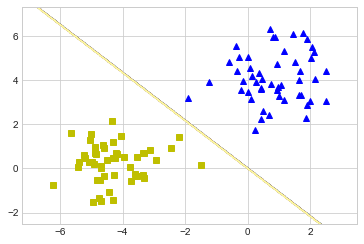

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import Perceptron

# Daten erstellen für das Lernen mit scikit-learn
# Wir erzeugen zwei Punkthaufen mit zwei Kategorien, die linear trennbar sind
# n_samples = Anzahl an Datenpunkten pro Kategorie
# n_features = Anzahl der Kategorien
# centers = Anzahl der Punkthaufen
# random_state = Seed für Zufallsgenerator
X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=2, random_state=3)
# Klassifikationen
# Aufbau eines Rasters, um auszuwerten und zu zeichen
s = 0.02 # Schrittweite im Raster
# Ermittlung der 1D-Arrays, die die Koordinaten im Raster repräsentieren
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # erste Koordinate
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # zweite Koordinate
# np.arange liefert ein ndarray mit gleichmäßig verteilten Werten
# np.meshgrid liefert Koordinatenmatrizen von Koordinatenvektoren
xx, yy = np.meshgrid(np.arange(x_min, x_max, s), np.arange(y_min, y_max, s))
# Das Perceptron instanziieren
# max_iter = Maximale Anzahl an Iterationen
# tol = Stoppkriterium
perceptron = Perceptron(random_state=42, max_iter=1000)
# Lernen, bitte!
perceptron.fit(X, y)
# Auswertung für alle Rasterpunkte, dazu wird ein Array aus Rasterpunkten erzeugt
# ravel() erzeugt ein 1D-Array
# np.c_ erzeugt ein Punktpärchen-Array für jeden Rasterpunkt, die als Input für
# das Perceptron dienen
prediction = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
# Daten anzeigen in einem Plot
# Zuerst Plotten der Punkthaufen
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'b^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'ys')
# Umwandlung von 1D-Array in die Rasterdimensionen
# [x_min, x_max] mal [y_min, y_max]
prediction = prediction.reshape(xx.shape)
# Plotten der Vorhersagen
plt.contour(xx, yy, prediction, cmap=plt.cm.Paired)
plt.show()

### Adaline

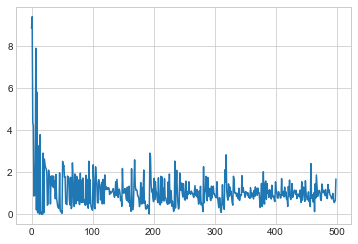

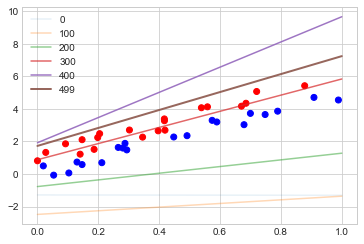

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

class AdalineEstimator(BaseEstimator, ClassifierMixin):
  def __init__(self, eta=.001, n_iterations=500, random_state=None):
    """ Initialisierung der Objekte
    eta: Lernrate
    n_iterations: Anzahl der Iterationen für das Lernen
    random_state: Um Wiederholbarkeit zu garantieren, sollte ein numpy.random.RandomState-Objekt
      initialisiert werden, das mit random_state als Seed initialisiert wurde
    """
    self.eta = eta
    self.n_iterations = n_iterations
    self.random_state = random_state
    # Die Fehler im Lernprozess für den Plot gepuffert
    self.errors = []
    # Gewichte für die Berechnung im KNN
    self.w = []
    # Alle Gewichte für Plot, zum Zeichnen der Trenngeraden
    self.wAll = []

  def net_i(self, x):
    """ Den gewichteten Input w*x berechnen
    x: Ein Vektor
    """
    return np.dot(x, self.w)

  def activation(self, x):
    """ Lineare Aktivierungsfunktion """
    return self.net_i(x)

  def output(self, x):
    """ Outputfunktion, wobei der Output 1 und -1 sein kann, im Gegensatz zum Perceptron, wo der
    Output 1 und 0 sein kann """
    if self.activation(x) >= 0.0:
      return 1
    return -1

  def fit(self, X=None, y=None):
    """ Trainieren
    X: Array-ähnliche Struktur mit [N, D], wobei
      N = Zeilen = Anzahl der Lernbeispiele und
      D = Spalten = Anzahl der Features
    y: Array mit [N], mit N so wie oben
    """
    # Erzeugung des Zufallsgenerators
    random_state = check_random_state(self.random_state)
    # Gewichtsinitialisierung
    # np.size(.,1) = Anzahl der Spalten
    self.w = random_state.random_sample(np.size(X, 1))
    # Prüfe, ob X und y die korrekte Shape haben: X.shape[0] == y.shape[0]
    X, y = check_X_y(X, y)
    # Lerndaten für spätere Verwendung ablegen
    self.X_ = X
    self.y_ = y
    # Lernen mit Gradientenabstieg
    for i in range(self.n_iterations):
      # zufälliges Durchwürfeln für batch size = 1
      # np.size(.,0) = Anzahl der Zeilen
      rand_index = random_state.randint(0, np.size(X, 0))
      # Ein zufälliger Inputvektor
      x_ = X[rand_index]
      # Der dazu passende Output (+1, -1)
      y_ = y[rand_index]
      # net input s berechnen
      s = np.dot(x_, self.w)
      # Fehler berechnen als Quadrat der Differenz zwischen
      # gewünschtem und tatsächlichem Output
      error = (y_ - s) ** 2
      self.errors.append(error)
      # Online-Adaline-Lernen
      self.w += self.eta * x_ * (y_ - s)
      self.wAll.append(self.w.copy())

  def predict(self, x):
    """ Auswerten eines Vektors
    x: Ein Test-Inputvektor
    """
    # Prüfen, ob fit ausgerufen wurde
    check_is_fitted(self, ['X_', 'y_'])
    # Auswerten, Forward Path
    y_hat = self.output(x)

    return y_hat

  def plot(self):
    """ Ausgeben des Fehlers und der Lernkurve
    Die Fehler im Fehlerarray als Grafik ausgeben
    Die Trenngeraden aus den gespeicherten Gewichten ausgeben
    """
    x1 = []
    x2 = []
    colors = []

    for i in range(self.X_.shape[0]):
      x1.append(self.X_[i][1])
      x2.append(self.X_[i][2])
      y = self.y_[i]
      if y == 1:
        colors.append('r')
      else:
        colors.append('b')
    
    # Raster
    plt.style.use('seaborn-whitegrid')
    # Errors
    plt.plot(self.errors)
    # Learning Curve
    plt.figure(1)
    plt.show()
    # Scatter
    plt.figure(2)
    plt.scatter(x1, x2, c=colors)
    # Result Line
    x1Line = np.linspace(0.0, 1.0, 2)
    x2Line = lambda x1, w0, w1, w2: (-x1 * w1 - w0) / w2
    alpha = 0.0

    for idx, weight in enumerate(self.wAll):
      if (idx % 100 == 0):
        alpha = min((idx + 50) / len(self.wAll), 1.0)
        plt.plot(x1Line, x2Line(x1Line, weight[0], weight[1], weight[2]), alpha=alpha, linestyle='solid', label=str(idx), linewidth=1.5)

    # Ergebnisgerade
    plt.plot(x1Line, x2Line(x1Line, weight[0], weight[1], weight[2]), alpha=alpha, linestyle='solid', label=str(idx), linewidth=2.0)
    plt.legend(loc='best', shadow=True)


def main():
  # Erzeugung des Zufallsgenerators
  random_state = check_random_state(1)
  # Initialisierung der Datensätze
  I = []
  o = []
  # Datensätze für zwei Kategorien aufbauen
  for x in random_state.random_sample(20):
    y = random_state.random_sample()
    I.append([1, x, y + 5*x + 0.5])
    o.append(1)
  
  for x in random_state.random_sample(20):
    y = random_state.random_sample()
    I.append([1, x, y + 5*x - 0.5])
    o.append(-1)

  # Trainingsdaten
  X = np.array(I)
  y = np.array(o)
  adaline = AdalineEstimator(eta=0.01, n_iterations=500, random_state=10)
  # Lernen
  adaline.fit(X, y)
  # Graphen ausgeben
  adaline.plot()

main()
